In [1]:
import os
import pickle
import tarfile
import datetime
import numpy as np
import urllib.request
import sklearn.metrics
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print('GPU enable')
    except:
        print('GPU not enable')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU enable


In [3]:
%load_ext tensorboard

In [3]:
HISTORY_DIR = 'C:/Users/dmitry/Desktop/Jupiter/dvfu_tasks/history'
os.makedirs(HISTORY_DIR, exist_ok=True)

In [4]:
def get_data():
    if not os.path.exists('cifar-10-batches-py/'):
        urllib.request.urlretrieve('https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz', 'cifar-10-python.tar.gz')
        file = tarfile.open('cifar-10-python.tar.gz', 'r:gz')
        file.extractall()
        
    X, y = [], []
    for i in range(1, 6):
        d = pickle.load(open(os.path.join('cifar-10-batches-py', f'data_batch_{i}'), 'rb'), encoding='bytes')
        X.append(d[b'data'])
        y.append(d[b'labels'])
        
    d = pickle.load(open(os.path.join('cifar-10-batches-py', 'test_batch'), 'rb'), encoding='bytes')
        
    return (
        np.concatenate(X, axis=0).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1),
        np.concatenate(y, axis=0),
        pickle.load(open('cifar-10-batches-py/batches.meta', 'rb'))['label_names'],
        np.array(d[b'data']).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1),
        np.array(d[b'labels'])
    )

In [5]:
def plot_confusion_matrix(model: tf.keras.models.Model, X: np.ndarray, y: np.ndarray, labels: list[str], batch_size: int = 64, **kwargs):
    _, ax = plt.subplots(figsize=(10, 10))
    sklearn.metrics.ConfusionMatrixDisplay.from_predictions(
        y,
        model.predict(X.reshape(-1, 32, 32, 3) / 255, verbose=False, batch_size=batch_size).argmax(axis=-1),
        display_labels=labels,
        xticks_rotation='vertical',
        ax=ax,
        **kwargs
    )

In [6]:
X, y, labels, X_test, y_test = get_data()

In [10]:
train_data = tf.data.Dataset.from_tensor_slices(X).map(lambda x: tf.cast(tf.reshape(x, (32, 32, 3)) / 255, tf.float32))
train_labels = tf.data.Dataset.from_tensor_slices(y)
train_dataset = tf.data.Dataset.zip((train_data, train_labels)).batch(64)

val_data = tf.data.Dataset.from_tensor_slices(X_test).map(lambda x: tf.cast(tf.reshape(x, (32, 32, 3)) / 255, tf.float32))
val_labels = tf.data.Dataset.from_tensor_slices(y_test)
val_dataset = tf.data.Dataset.zip((val_data, val_labels)).batch(64)

In [12]:
inputs = tf.keras.layers.Input((32, 32, 3), name='input')

x = tf.keras.layers.Conv2D(32, 3, padding='same')(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.PReLU()(x)


x = tf.keras.layers.Conv2D(32, 3, padding='same')(x)
x = tf.keras.layers.PReLU()(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.MaxPool2D((2, 2))(x)
x = tf.keras.layers.Dropout(0.2)(x)


x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
x = tf.keras.layers.PReLU()(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
x = tf.keras.layers.PReLU()(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.MaxPool2D((2, 2))(x)
x = tf.keras.layers.Dropout(0.3)(x)


x_res = tf.keras.layers.Conv2D(256, 3, padding='same')(x)
x_res = tf.keras.layers.BatchNormalization()(x_res)
x_res = tf.keras.layers.PReLU()(x_res)

x_res = tf.keras.layers.Conv2D(64, 3, padding='same')(x_res)
x_res = tf.keras.layers.BatchNormalization()(x_res)
x_res = tf.keras.layers.PReLU()(x_res)

x = tf.keras.layers.add([x, x_res])

x = tf.keras.layers.Conv2D(128, 3, padding='same')(x)
x = tf.keras.layers.PReLU()(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(128, 3, padding='same')(x)
x = tf.keras.layers.PReLU()(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.MaxPool2D((2, 2))(x)
x = tf.keras.layers.Dropout(0.4)(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128)(x)
x = tf.keras.layers.PReLU()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(10)(x)
x = tf.keras.layers.Softmax()(x)


In [13]:
model = tf.keras.Model(inputs=inputs, outputs=x, name='ciaonima-10')

In [14]:
model.summary()

Model: "ciaonima-10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_18 (Conv2D)             (None, 32, 32, 32)   896         ['input[0][0]']                  
                                                                                                  
 batch_normalization_17 (BatchN  (None, 32, 32, 32)  128         ['conv2d_18[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 p_re_lu_17 (PReLU)             (None, 32, 32, 32)   32768       ['batch_normalization_1

In [15]:
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy', optimizer='adam')

In [16]:
logdir = os.path.join(HISTORY_DIR, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [17]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(logdir, 'model'),
    save_best_only=True
)

In [18]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    os.path.join(logdir, 'logs'),
    write_graph=True   
)

In [51]:
%tensorboard --logdir $logdir

In [20]:
model.fit(train_dataset, validation_data=val_dataset, epochs=10, callbacks=[model_checkpoint_callback, tensorboard_callback])

Epoch 1/10
782/782 [==============================] - 24s 31ms/step - loss: 0.0814 - accuracy: 0.9718 - val_loss: 0.7247 - val_accuracy: 0.8495
Epoch 2/10
782/782 [==============================] - 25s 31ms/step - loss: 0.0796 - accuracy: 0.9719 - val_loss: 0.7382 - val_accuracy: 0.8490
Epoch 3/10
782/782 [==============================] - 24s 31ms/step - loss: 0.0791 - accuracy: 0.9728 - val_loss: 0.7901 - val_accuracy: 0.8400
Epoch 4/10
782/782 [==============================] - 25s 31ms/step - loss: 0.0784 - accuracy: 0.9735 - val_loss: 0.6834 - val_accuracy: 0.8518
Epoch 5/10
782/782 [==============================] - 26s 33ms/step - loss: 0.0721 - accuracy: 0.9750 - val_loss: 0.6739 - val_accuracy: 0.8560
Epoch 6/10
782/782 [==============================] - 24s 31ms/step - loss: 0.0713 - accuracy: 0.9747 - val_loss: 0.7917 - val_accuracy: 0.8424
Epoch 7/10
782/782 [==============================] - 24s 30ms/step - loss: 0.0698 - accuracy: 0.9759 - val_loss: 0.7849 - val_accuracy:

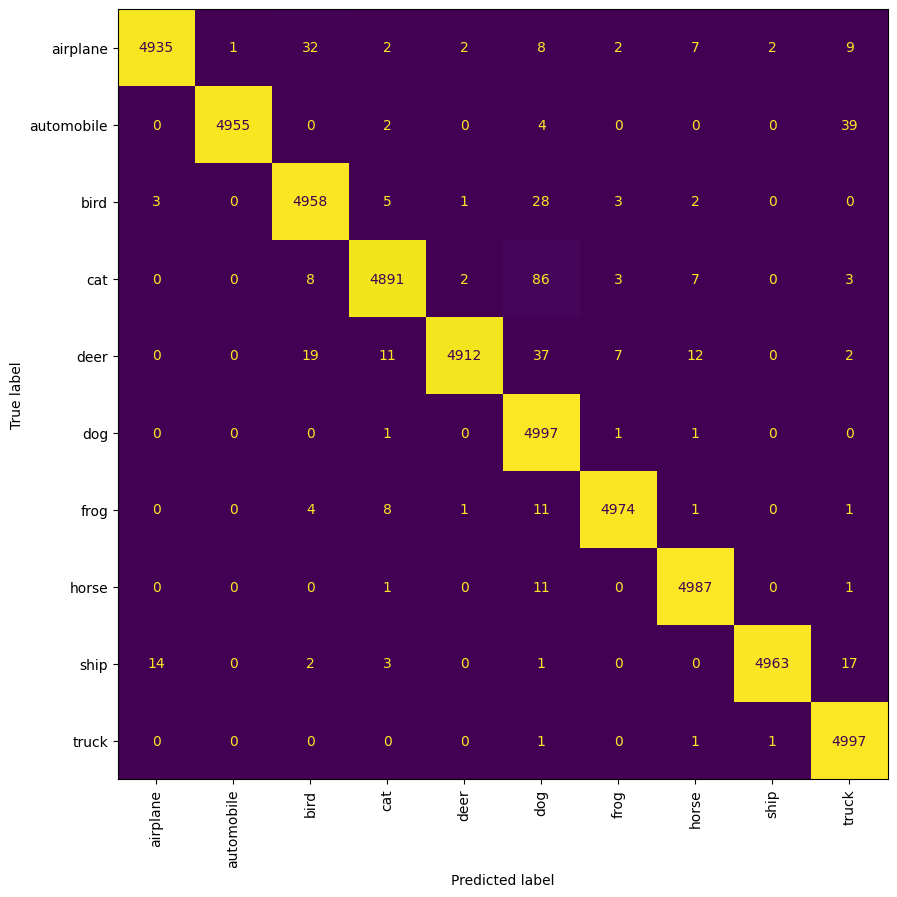

In [21]:
plot_confusion_matrix(model, X, y, labels=labels, colorbar=False)

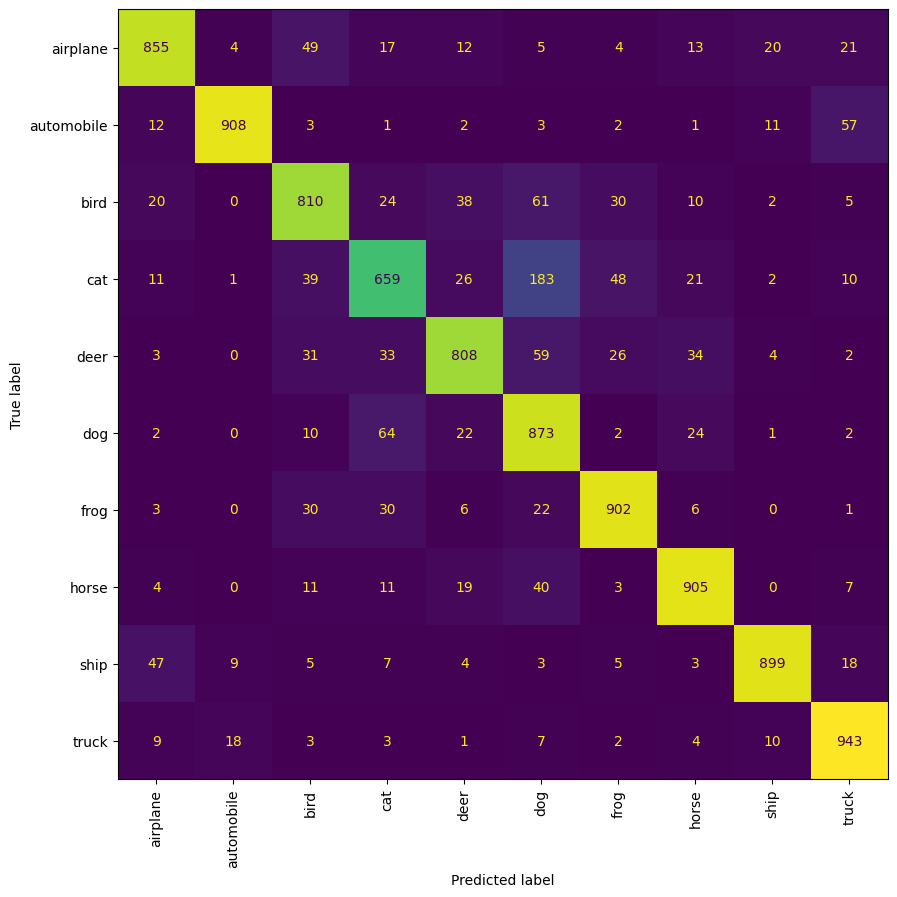

In [22]:
plot_confusion_matrix(model, X_test, y_test, labels=labels, colorbar=False)

In [23]:
y_pred = model.predict(X_test.reshape(-1, 32, 32, 3) / 255, verbose=False).argmax(axis=-1)

In [24]:
accuracy = y_test == y_pred
np.mean([np.mean(accuracy[y_test == i]) for i in range(10)])

0.8562000000000001